In [1]:
from methods import *
from hyperseed_v2 import *

In [2]:
DIC= dict(zip(range(1,11),range(0,10)))

In [3]:
from mnist import MNIST
import numpy as np
mndata = MNIST("..\\Hyperseed\\Data\\MNIST\\")
np.random.seed(0)
imagesTrain, labelsTrain = mndata.load_training()

# or
imagesTest, labelsTest = mndata.load_testing()
    
imagesTrain, labelsTrain = np.array(imagesTrain), np.array(labelsTrain)
imagesTest, labelsTest = np.array(imagesTest), np.array(labelsTest)
trainSize = 5000
testSize = 2000
trainImageSet,trainLabelSet = imagesTrain[:trainSize]/255,labelsTrain[:trainSize]
inferImageSet, inferLabelSet = imagesTest[:testSize]/255,labelsTest[:testSize]



trX,trY = trainImageSet,trainLabelSet
teX,teY = inferImageSet,inferLabelSet

In [4]:
trainLabelSet

array([5, 0, 4, ..., 2, 1, 2], dtype=uint8)

In [5]:


def genData(d):


    X,y = trX[:],trY[:]
    X_test,y_test = teX[:],teY[:]# trX[tSize:],trY[tSize:]#teX[:],teY[:]
    bits = d

    from sklearn import decomposition
    pca = decomposition.PCA()
    compSize=784#784#300


    #### Random project data from 784 to dimension d

    np.random.seed(4) ## 4
    rnd_project =  2 * np.pi * np.random.rand(compSize, bits) # random angles
    rnd_project = 1 * np.exp(1j * rnd_project).real # create a phasor vector


    print(X.shape,rnd_project.shape)
    TR_D = np.matmul(X,rnd_project)#X#np.matmul(X,rnd_project)
    TR_D_test=np.matmul(X_test,rnd_project)#X_test#np.matmul(X_test,rnd_project)


    d = bits

    ### Use fft to make the vectors complex

    HD_X_shuffeled,y_shuffeled = np.fft.fft(TR_D),y
    HD_X_shuffeled_test,y_shuffeled_test = np.fft.fft(TR_D_test),y_test


    numClasses=10
    num_classes=numClasses
    classes = [[] for _ in range(numClasses)]
    classes_test = [[] for _ in range(numClasses)]
    for i in range(len(HD_X_shuffeled)):
        classes[int(y_shuffeled[i])].append(HD_X_shuffeled[i])

    for i in range(len(HD_X_shuffeled_test)):
        classes_test[int(y_shuffeled_test[i])].append(HD_X_shuffeled_test[i])


    samplesPerClass=[len(i) for i in classes]
    samplesPerClassTest=[len(i) for i in classes_test]

    selected_classes= range(10)#[0,1,2,3, 4]# range(10)# [0,1,2,3, 4]
    TR_perm = np.concatenate(([classes[i] for i in selected_classes]), axis = 0)
    TR_L_perm = np.concatenate(([[i+1]*samplesPerClass[i] for i in selected_classes]), axis = 0)

    TE_perm = np.concatenate(([classes_test[i] for i in selected_classes]), axis = 0)
    TE_L_perm = np.concatenate(([[i+1]*samplesPerClassTest[i] for i in selected_classes]), axis = 0)
    
    return [TR_perm,TR_L_perm,TE_perm,TE_L_perm]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn import decomposition

In [7]:
levels=100
nodes=100
sim_bases=0.015#15
sim_baseVSacc=[]
for d in [400, 800, 1600, 2500, 5000]:
    ppp=0
    accPCA =[]
    accHyperbase = []
    while(ppp<3):
        TR_perm,TR_L_perm,TE_perm,TE_L_perm = genData(d)
        TR_perm_pca,TE_perm_pca = np.fft.ifft(TR_perm).real,np.fft.ifft(TE_perm).real
        pca = decomposition.PCA()
        pca.n_components = levels
        model = pca.fit(TR_perm_pca)#
        trainImageSet_pca=model.transform(TR_perm_pca)
        inferImageSet_pca=model.transform(TE_perm_pca)

        model = KNeighborsClassifier(n_neighbors=3)# LogisticRegression(random_state=0)
        # model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        model.fit(trainImageSet_pca, TR_L_perm-1)
        prediction_pca = model.predict(inferImageSet_pca)
        acc_pca=np.round(classification_report(TE_L_perm-1, prediction_pca,output_dict=True)["accuracy"],3)

        seed,bases,CodeBooks=HyperSeed_2(TR_perm,TR_L_perm,TE_perm,TE_L_perm,sim_bases,levels,nodes,d)
        trainData, trainLabels= [],[]
        samples=[]
        results=[]
        stats= np.zeros((levels,nodes))
        for i in range(len(TR_perm)):
            hd_new = TR_perm[i];
            Ibmu = seed * np.conj(hd_new);
            inds,work=findCoordinates(Ibmu,CodeBooks)
            for j in range(len(inds)):
                stats[j][int(inds[j])]+=1
            trainData.append(inds.astype('int'))
            samples.append(hd_new)
            results.append(inds.astype('int'))
            trainLabels.append(TR_L_perm[i])
        trainData= np.array(trainData).real

        testData, testLabels= [],[]
        for i in range(len(TE_perm)):
            hd_new = TE_perm[i];
            Ibmu = seed * np.conj(hd_new);
            inds,work=findCoordinates(Ibmu,CodeBooks)
            testData.append(inds.astype('int'))
            testLabels.append(TE_L_perm[i])
        testData=np.array(testData).real
        trainLabels=np.array(trainLabels)
        testLabels=np.array(testLabels)




        model = KNeighborsClassifier(n_neighbors=3)# LogisticRegression(random_state=0)
        # model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        # LR_classifier.fit(trainData, trainLabels)
        model.fit(trainData, trainLabels-1)
        prediction = model.predict(testData)

        print(classification_report(testLabels-1, prediction))
        acc=np.round(classification_report(testLabels-1, prediction,output_dict=True)["accuracy"],3)
        accPCA.append(acc_pca)
        accHyperbase.append(acc)
        ppp+=1
    sim_baseVSacc.append([d,sum(accHyperbase)/len(accHyperbase),sum(accPCA)/len(accPCA)])
#     sim_bases+=0.002

(5000, 784) (784, 400)
SELECTED sample:  1816
SELECTED sample:  2049
SELECTED sample:  2486
SELECTED sample:  2396
SELECTED sample:  4941
SELECTED sample:  3142
SELECTED sample:  1155
SELECTED sample:  4040
SELECTED sample:  500
SELECTED sample:  120
SELECTED sample:  2717
SELECTED sample:  926
SELECTED sample:  2082
SELECTED sample:  930
SELECTED sample:  3062
SELECTED sample:  1144
SELECTED sample:  3541
SELECTED sample:  558
SELECTED sample:  446
SELECTED sample:  4829
SELECTED sample:  3418
SELECTED sample:  4661
SELECTED sample:  528
SELECTED sample:  3567
SELECTED sample:  4924
SELECTED sample:  28
SELECTED sample:  3098
SELECTED sample:  2397
SELECTED sample:  3865
SELECTED sample:  1087
SELECTED sample:  103
SELECTED sample:  98
SELECTED sample:  2818
SELECTED sample:  3509
SELECTED sample:  837
SELECTED sample:  4442
SELECTED sample:  1222
SELECTED sample:  3152
SELECTED sample:  114
SELECTED sample:  2370
SELECTED sample:  177
SELECTED sample:  2006
SELECTED sample:  3412
SEL

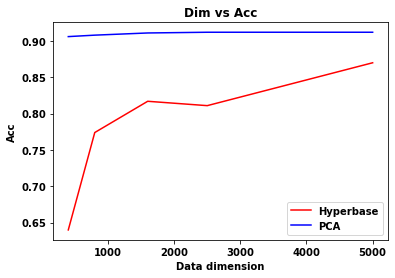

In [8]:
# data to be plotted
x = np.array(sim_baseVSacc)[:,0]
y = np.array(sim_baseVSacc)[:,1]
z = np.array(sim_baseVSacc)[:,2] 
# plotting
plt.title("Dim vs Acc")
plt.xlabel("Data dimension")
plt.ylabel("Acc")
plt.plot(x, y, color ="red" ,label='Hyperbase')
plt.plot(x, z, color ="blue", label='PCA')
plt.legend()
plt.show()